In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pennylane as qml
import warnings
warnings.filterwarnings("ignore")

In [50]:
from sklearn.datasets import load_wine
data = load_wine()
X, y = data.data, data.target

In [51]:
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [52]:
print(data.feature_names)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [53]:
print(data.target_names)

['class_0' 'class_1' 'class_2']


In [54]:
print("Features shape:", data.data.shape)
print("Target shape:", data.target.shape)

Features shape: (178, 13)
Target shape: (178,)


In [55]:
print("First 5 samples:\n", data.data[:5])
print("First 5 targets:\n", data.target[:5])

First 5 samples:
 [[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
  2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 1.120e+01 1.000e+02 2.650e+00 2.760e+00
  2.600e-01 1.280e+00 4.380e+00 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
  3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]
 [1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
  2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
 [1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
  3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]]
First 5 targets:
 [0 0 0 0 0]


In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [57]:
n_qubits = 13
dev = qml.device("default.qubit", wires=n_qubits)

# Feature embedding for Naive Bayes
@qml.qnode(dev)
def encode_features(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)
        qml.RX(x[i], wires=i)
        qml.CZ(wires=[i, (i + 1) % n_qubits])
    return qml.state()

In [58]:
def compute_class_means(X, y):
    class0_vectors = [encode_features(x) for x, label in zip(X, y) if label == 0]
    class1_vectors = [encode_features(x) for x, label in zip(X, y) if label == 1]
    mean0 = np.mean(class0_vectors, axis=0)
    mean1 = np.mean(class1_vectors, axis=0)
    return mean0, mean1

mean0, mean1 = compute_class_means(X_train, y_train)

In [59]:
def predict_naive_bayes(X_test, mean0, mean1):
    predictions = []
    for x in X_test:
        state = encode_features(x)
        sim0 = np.abs(np.dot(np.conj(mean0), state))**2
        sim1 = np.abs(np.dot(np.conj(mean1), state))**2
        predictions.append(0 if sim0 > sim1 else 1)
    return np.array(predictions)

preds = predict_naive_bayes(X_test, mean0, mean1)

In [60]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test, preds)
print(f"Wine Classifier Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=data.target_names))


Wine Classifier Accuracy: 69.44%

Classification Report:
              precision    recall  f1-score   support

     class_0       0.86      1.00      0.92        12
     class_1       0.59      0.93      0.72        14
     class_2       0.00      0.00      0.00        10

    accuracy                           0.69        36
   macro avg       0.48      0.64      0.55        36
weighted avg       0.52      0.69      0.59        36



In [61]:
new_sample = [[1.423e+01, 1.710e+00 ,2.430e+00, 1.560e+01 ,1.270e+02, 2.800e+00, 3.060e+002, 0.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00, 1.065e+03]] 
new_sample_scaled = scaler.transform(new_sample)

state = encode_features(new_sample_scaled[0])
sim0 = np.abs(np.dot(np.conj(mean0), state))**2
sim1 = np.abs(np.dot(np.conj(mean1), state))**2

predicted_label = 0 if sim0 > sim1 else 1
print(f"\nPrediction for new sample: {predicted_label}")


Prediction for new sample: 0


Text(0.5, 1.0, 'Quantum Naive Bayes - Feature Encoding Circuit')

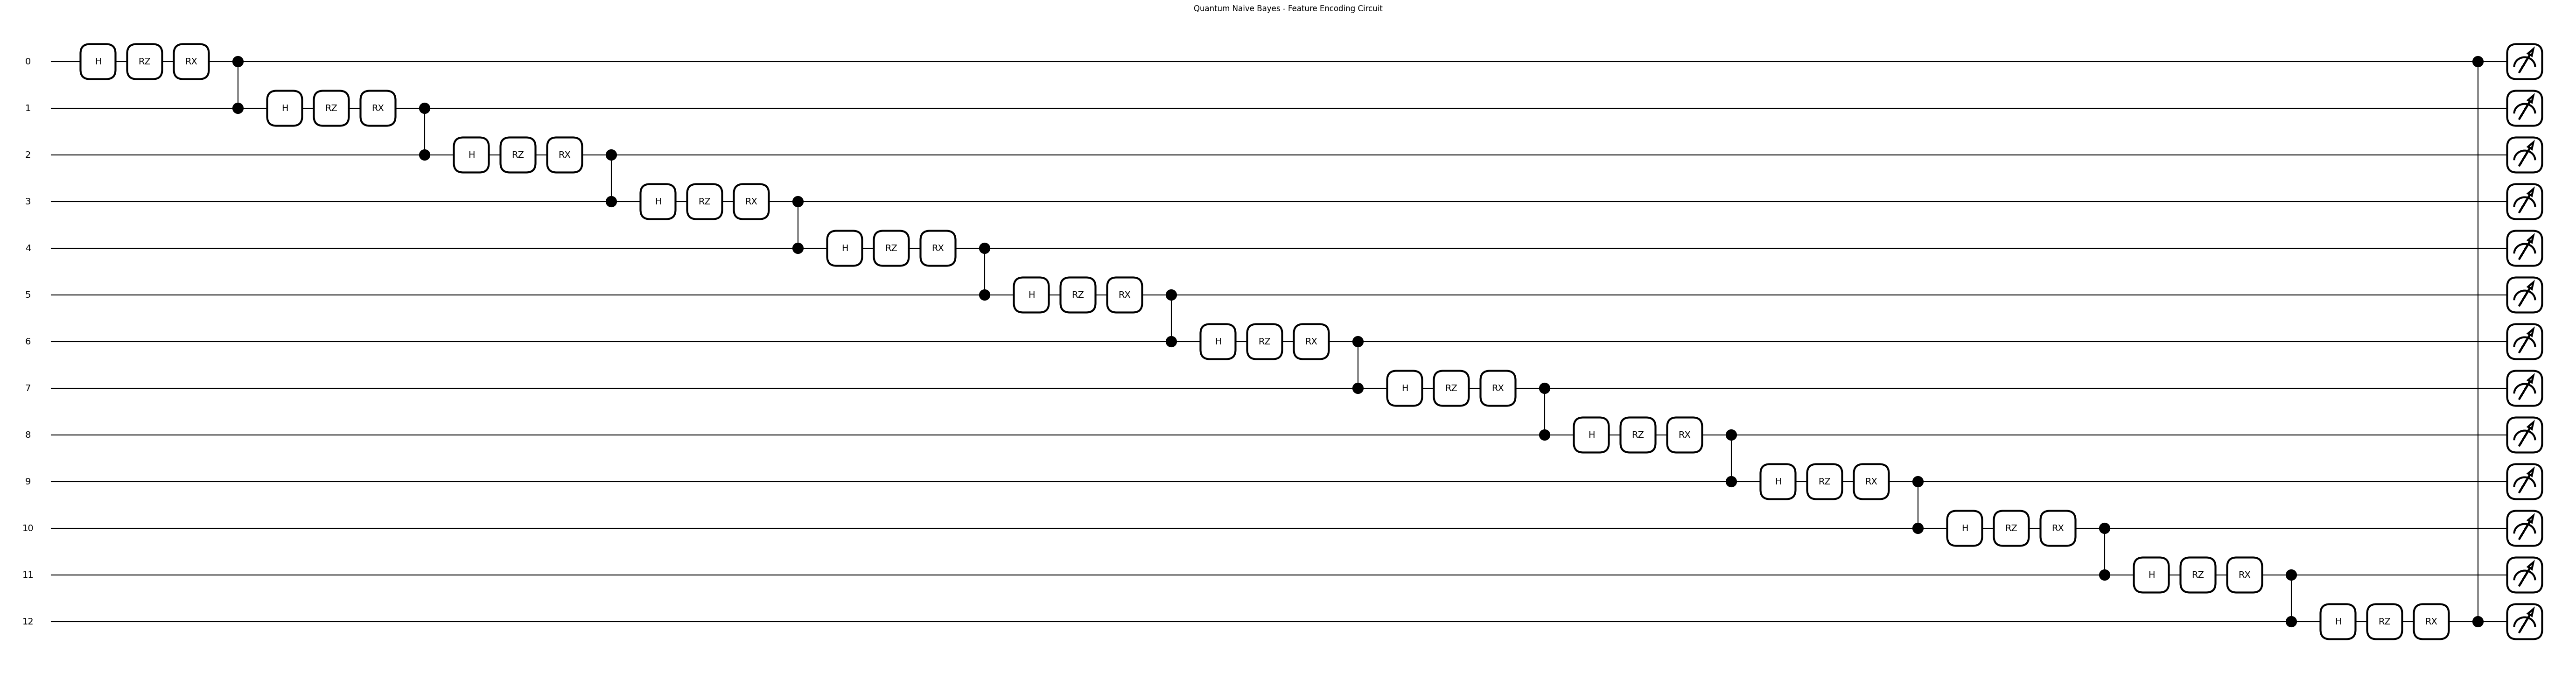

In [62]:
@qml.qnode(dev)
def draw_encode(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)
        qml.RX(x[i], wires=i)
        qml.CZ(wires=[i, (i + 1) % n_qubits])
    return qml.state()

fig, ax = qml.draw_mpl(draw_encode)(X_train[0])
ax.set_title("Quantum Naive Bayes - Feature Encoding Circuit")